In [1]:
%cd ~/user_data/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base
%pwd

/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base


'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base'

In [2]:
import random
import numpy as np
import torch
from torchvision.datasets import CocoDetection
from PIL import ImageDraw
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import pandas as pd

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/home/DREXEL/jw3897/miniconda3/envs/owlvit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
val_image_dir = r'/mnt/active_storage/Joe/coco_set/val2017/images'
novel_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/ovd_ins_val2017_t.json'

novel_coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=novel_annotation_path,
)

base_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/ovd_ins_val2017_b.json'

base_coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=base_annotation_path,
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [5]:
print(f"Num Images in COCO Base: {len(base_coco_val_dataset)}")
print(f"Num Images in COCO Novel: {len(novel_coco_val_dataset)}")

Num Images in COCO Base: 4533
Num Images in COCO Novel: 2064


In [6]:
base_image_ids = []
for item in base_coco_val_dataset:
    base_image_ids.append(item[1][0]['image_id'])

novel_image_ids = []
for item in novel_coco_val_dataset:
    novel_image_ids.append(item[1][0]['image_id'])

shared_image_ids = list(set(base_image_ids).intersection(set(novel_image_ids)))
shared_image_ids.sort()

print(f"Num Shared Images: {len(shared_image_ids)}")

Num Shared Images: 1761


In [7]:
shared_coco_val_dataset = []
for item in novel_coco_val_dataset:
    metadata_idx = 1
    image_id = item[metadata_idx][0]['image_id']
    if image_id in shared_image_ids:
        shared_coco_val_dataset.append(item)

1761


In [8]:
category_names = ['airplane', 'bus', 'cat', 'dog', 'cow', 'elephant', 'umbrella', \
    'tie', 'snowboard', 'skateboard', 'cup', 'knife', 'cake', 'couch', 'keyboard', \
    'sink', 'scissors']

In [9]:
category_ids = novel_coco_val_dataset.coco.loadCats(novel_coco_val_dataset.coco.getCatIds())

targets = []
target_boxes = []
target_labels = []

for idx, image_tuple in enumerate(shared_coco_val_dataset):
    image = image_tuple[0]
    annotations = image_tuple[1]
    
    for annotation in annotations:
        label_name = [category['name'] for category in category_ids if category['id'] == annotation['category_id']][0]

        try:
            label = category_names.index(label_name)
        except ValueError as e:
            # If the annotation is not part of the novel categories, skip it
            continue

        # xmin, ymin, width, height -> xmin, ymin, xmax, ymax
        box = annotation['bbox']
        bbox = []
        bbox.append(int(round(box[0])))
        bbox.append(int(round(box[1])))
        bbox.append(int(round(box[0] + box[2])))
        bbox.append(int(round(box[1] + box[3])))

        target_boxes.append(bbox)
        target_labels.append(label)

    target_boxes = torch.tensor(target_boxes, dtype=torch.int)
    target_labels = torch.tensor(target_labels, dtype=torch.int)

    target_image_dict = {
        'image_id': shared_image_ids[idx],
        'boxes': target_boxes,
        'labels': target_labels
    }

    targets.append(target_image_dict)

    # Clear boxes and labels
    target_boxes = []
    target_labels = []

# Evaluation Code

In [10]:
%pwd

'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base'

In [ ]:
predictions_df_total = pd.read_parquet(r'/mnt/active_storage/Joe/owlvit_results/unknown_objects_updated_with_novel_labels_obj2_cls1_clipvitbase32.parquet')

In [13]:
objectness_threshold = 0.2
score_threshold = 0.1
min_dim = 0

relevant_image_objects = predictions_df_total.loc[predictions_df_total['image_id'].isin(shared_image_ids)]

confident_objects = relevant_image_objects[relevant_image_objects['score'] >= score_threshold]
unconfident_objects = relevant_image_objects[relevant_image_objects['score'] < score_threshold]

confident_objects_sizelimited = confident_objects[((confident_objects['xmax'] - confident_objects['xmin']) > min_dim) & ((confident_objects['ymax'] - confident_objects['ymin']) > min_dim)]

print(f"Number of Confident Annotations: {len(confident_objects)}\n \
Number of Confident Annotations Sizelimited: {len(confident_objects_sizelimited)}\n \
Number of Unconfident Annotations: {len(unconfident_objects)}")

,image_id,label,score,objectness_score,xmin,ymin,xmax,ymax
55279,1503,knife,0.276153,0.369445,96.540100,103.998489,120.847557,161.302979
55594,1503,sink,0.471443,0.245349,134.416107,111.131279,205.046005,159.928574
55938,1503,keyboard,0.994812,0.269581,0.308208,130.165726,317.193298,240.838318
55196,1503,tie,0.375620,0.404980,279.463531,93.532410,320.128601,152.998123
54411,1503,knife,0.464695,0.263020,268.243256,6.110020,295.819580,101.931030
...,...,...,...,...,...,...,...,...
167589,581357,tie,0.367143,0.234230,25.962440,337.826660,107.538383,359.686493
168248,581357,tie,0.203935,0.646139,49.977936,327.986267,123.944717,518.138794
166413,581357,cake,0.324012,0.302958,316.926239,114.625443,362.680420,152.093796
167888,581357,umbrella,0.263183,0.206565,61.052029,328.466461,102.281570,410.364929


,image_id,label,score,objectness_score,xmin,ymin,xmax,ymax


Number of Confident Annotations: 13878
 Number of Confident Annotations Sizelimited: 13878
 Number of Unconfident Annotations: 0


In [14]:
predictions_dict = confident_objects_sizelimited.to_dict('records')

In [16]:
preds = []
pred_boxes = []
pred_scores = []
pred_objectness_scores = []
pred_labels = []

current_img_id = predictions_dict[0]['image_id']
for prediction in predictions_dict:
    # If on a new image...
    if prediction['image_id'] != current_img_id:
        # Convert boxes, scores, and labels to tensors
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
        pred_scores = torch.tensor(pred_scores, dtype=torch.float)
        pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
        pred_labels = torch.tensor(pred_labels, dtype=torch.int)

        # Create the dict for preds
        pred_image_dict = {
            'image_id': current_img_id,
            'boxes': pred_boxes,
            'scores': pred_scores,
            'objectness_scores': pred_objectness_scores,
            'labels': pred_labels
        }

        preds.append(pred_image_dict)

        # Clear boxes, scores, and labels for the new image
        pred_boxes = []
        pred_scores = []
        pred_objectness_scores = []
        pred_labels = []

        # Set new current image id
        current_img_id = prediction['image_id']

    bbox = []
    bbox.append(prediction['xmin'])
    bbox.append(prediction['ymin'])
    bbox.append(prediction['xmax'])
    bbox.append(prediction['ymax'])

    pred_boxes.append(bbox)
    pred_scores.append(prediction['score'])
    pred_objectness_scores.append(prediction['objectness_score'])
    pred_labels.append(category_names.index(prediction['label']))

# Capture the predictions for the last image
pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
pred_scores = torch.tensor(pred_scores, dtype=torch.float)
pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
pred_labels = torch.tensor(pred_labels, dtype=torch.int)

# Create the dict for preds
pred_image_dict = {
    'image_id': current_img_id,
    'boxes': pred_boxes,
    'scores': pred_scores,
    'objectness_scores': pred_objectness_scores,
    'labels': pred_labels
}

preds.append(pred_image_dict)

In [20]:
pred_image_ids = np.unique([pred['image_id'] for pred in preds])
missing_ids = list(set(shared_image_ids) - set(pred_image_ids))
missing_ids.sort()

for missing_id in missing_ids:
    missing_id_dict = {
        'image_id': missing_id,
        'boxes': torch.tensor([], dtype=torch.int),
        'scores': torch.tensor([], dtype=torch.float),
        'objectness_scores': torch.tensor([], dtype=torch.float),
        'labels': torch.tensor([], dtype=torch.int),
    }
    preds.insert(shared_image_ids.index(missing_id), missing_id_dict)

In [21]:
assert len(preds) == len(shared_coco_val_dataset)
for idx in range (len(preds)):
    assert preds[idx]['image_id'] == shared_image_ids[idx]

{'image_id': 1503, 'boxes': tensor([[ 96, 103, 120, 161],
        [134, 111, 205, 159],
        [  0, 130, 317, 240],
        [279,  93, 320, 152],
        [268,   6, 295, 101],
        [234, 131, 262, 157],
        [126, 141, 158, 174],
        [163, 152, 315, 198],
        [  0, 170, 102, 215]], dtype=torch.int32), 'scores': tensor([0.2762, 0.4714, 0.9948, 0.3756, 0.4647, 0.2947, 0.3313, 0.4394, 0.9836]), 'objectness_scores': tensor([0.3694, 0.2453, 0.2696, 0.4050, 0.2630, 0.4282, 0.4866, 0.8350, 0.2088]), 'labels': tensor([11, 15, 14,  7, 11, 11, 15, 14, 14], dtype=torch.int32)}
1503
{'image_id': 1584, 'boxes': tensor([[504, 315, 568, 383],
        [526, 316, 569, 384],
        [126,  89, 521, 533],
        [501, 317, 526, 383]], dtype=torch.int32), 'scores': tensor([0.9906, 0.9479, 0.9999, 0.2624]), 'objectness_scores': tensor([0.6540, 0.2014, 0.5937, 0.2578]), 'labels': tensor([ 1,  1,  1, 11], dtype=torch.int32)}
1584
{'image_id': 1761, 'boxes': tensor([[ 30, 432, 411, 618],
    

{'image_id': 25603, 'boxes': tensor([[ 66,  47,  94,  76],
        [317,   0, 338,  21],
        [202, 316, 481, 418],
        [429, 355, 525, 425],
        [  9, 355, 292, 480],
        [150, 177, 379, 286],
        [266,  51, 315,  98],
        [524, 327, 576, 373],
        [  4, 275, 630, 479],
        [359, 294, 372, 315],
        [313, 318, 397, 479],
        [ 35, 406, 153, 480]], dtype=torch.int32), 'scores': tensor([0.2929, 0.2097, 0.4012, 0.3370, 0.3561, 0.1542, 0.1308, 0.2994, 0.4184,
        0.2606, 0.6071, 0.2365]), 'objectness_scores': tensor([0.2169, 0.2444, 0.3765, 0.2147, 0.2951, 0.2051, 0.2138, 0.4239, 0.2567,
        0.3305, 0.4687, 0.4071]), 'labels': tensor([11, 16, 10,  3, 12, 10,  8,  7,  7, 11, 10, 12], dtype=torch.int32)}
25603
{'image_id': 25986, 'boxes': tensor([[  0, 251, 154, 431],
        [512, 117, 562, 154],
        [373, 201, 448, 301],
        [108, 310, 402, 481],
        [351,  34, 499,  80],
        [279,  35, 497,  88],
        [384, 112, 584, 180],

In [22]:
for idx in range(len(targets)):
    assert targets[idx]['image_id'] == preds[idx]['image_id']

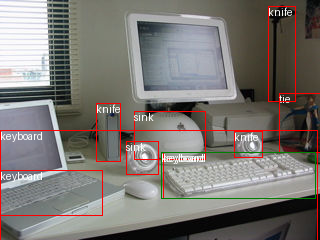

In [ ]:
# Visualize some preds and targets
index = 0

visualized_image = shared_coco_val_dataset[index][0].copy()

draw = ImageDraw.Draw(visualized_image)

for box, label in zip(preds[index]['boxes'], preds[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='red')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

for box, label in zip(targets[index]['boxes'], targets[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='green')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

visualized_image.save('clipvitbase32_cocoshared_example.png')

In [25]:
metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_type='bbox',
    iou_thresholds=None, # Defaults to trying from 0.5 -> 0.95 in steps of 0.05 
    rec_thresholds=None,
    max_detection_thresholds=None, # Uses [1, 10, 100]
    class_metrics=False,
    extended_summary=False, # This way, we can see the ious and scores calculated
    average='macro',
    backend='pycocotools'
)

metric.update(preds, targets)

In [26]:
computed_metric = metric.compute()

In [27]:
print(f"Objectness Threshold: {objectness_threshold}; Score Threshold: {score_threshold}; Min Dim: {min_dim}")
print(f"mAP: {round(computed_metric['map'].item(), 4):.4f}\nNum Objects: {len(predictions_dict)}")

Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 0
mAP: 0.1742
Num Objects: 13878


Objectness Threshold: 0.2; Score Threshold: 0.1; Min Dim: 0
mAP: 0.1742
Num Objects: 13878